- By: Ashutosh Singh
- Email: singh.ashu@gmail.com
- Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 75


# Fractionally Differentiated Features

One of the challenges of quantitative analysis in finance is that price time series have trends or non-constant mean. This makes the time series non-stationary.  Non-stationary time series are hard to work with when we want to do inferential analysis such as average and variance of returns, or probability of loss.  Stationary series also help in supervised learning methods. Specifically, in supervised learning one needs to map hitherto unseen observations to a set of labeled examples and determine the label of the new observation.  As Marcos Lopez de Prado (MLdP) says in Chapter 5, “if the features are not stationary we cannot map the new observation to a large number of known examples”.  However, to make a time series (or a feature) stationary often requires data transformations like computing changes (change in price, yields or volatility).  These transformations also leave the time series bereft of any memory and thereby reducing or eliminating its predictive capability.  This chapter discusses ways to preserve as much memory as possible while transforming the series into a stationary time series. Or, proverbially “to have your cake and eat it too”.

In this notebook we provide solutions to the exercies 5.1 through 5.6 and illustrate how fractionally differentiated series can be made stationary.  Exercises are particularly helpful in showing how to use fractionally differentaited series as a feature to train an algorithm.  Parts 5.6 (d) will be in a different notebook.

In [1]:
# import
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.stats import jarque_bera
from scipy.stats import linregress
from scipy.optimize import curve_fit 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

In [2]:
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
from mlfinlab.util import utils
from mlfinlab.features import fracdiff

In [3]:
%matplotlib inline

In [4]:
adf = lambda s: adfuller(s, autolag='AIC')
p_val = lambda s: adfuller(s, autolag='AIC')[1]

# 5.1 Generate a time series from an IID Gaussian random process.  This is a memory-less, stationary process

In [5]:
# generate 10000 IID random numbers 
nsample = 32768
mu = 0
sd = 1
ts = np.random.normal(mu, sd, nsample)

Text(0.5, 1.0, 'IID Series')

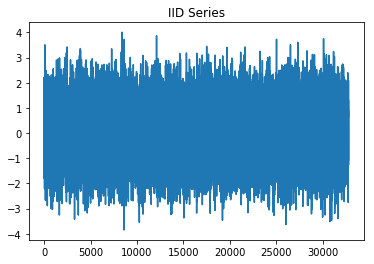

In [6]:
# plot the numbers
plt.plot(ts)
plt.title('IID Series')

In [7]:
# print various statistics of the time series
print('Mean: {:.4f}, SD: {:.4f}, Skewness: {:.4f}, Kurtosis: {:.4f}'.format(np.mean(ts), np.std(ts), st.skew(ts), st.kurtosis(ts)))

Mean: 0.0011, SD: 0.9956, Skewness: 0.0123, Kurtosis: -0.0136


## 5.1(a) Compute the ADF statistics on this series. What is the p-value?

In [8]:
adf_test = adfuller(ts, autolag='AIC')
print(adf_test)

(-180.65010522547405, 0.0, 0, 32767, {'1%': -3.430549585325409, '5%': -2.8616282115925373, '10%': -2.5668169522912225}, 92549.21523282514)


*The p-value is 0.0 and the abs(statistics) is very large compared to the critical value at 1% level, so we reject the null 
that there is a unit root*

## 5.1 b: Compute the cumulative sum of the observations.  This is a non-stationary series with memory

In [9]:
cumsum_ts = np.cumsum(ts)
print(adf(cumsum_ts))
print(p_val(cumsum_ts))

(-1.8081285628842634, 0.3764336208930048, 0, 32767, {'1%': -3.430549585325409, '5%': -2.8616282115925373, '10%': -2.5668169522912225}, 92545.96354422788)
0.3764336208930048


*The adfuller test shows that p-value (0.12) is not close to zero and the stat is not near the critical value of 1%.  Hence the series is not stationary as stated in the question.*  

### 5.1.b.i Compute the order of integration of this cumulative series

We know that I(0) is not stationary (see above) ... Let's check I(1)

In [10]:
# I(1)
i1_series = np.ediff1d(cumsum_ts)

In [11]:
i1_series[0:10]

array([-1.21533801, -0.27603693,  0.39522217,  1.42116852,  0.77997257,
        0.21814338,  1.00442459,  1.28326557, -1.62133003,  0.98999368])

In [12]:
print(adf(i1_series))

(-180.6479318366841, 0.0, 0, 32766, {'1%': -3.430549591417119, '5%': -2.861628214284826, '10%': -2.56681695372426}, 92547.03751182239)


*The p-value is 0 indicating that the series is stationary*

## 5.1 c: Differentiate the series twice. What is the p-value of this over-differentiated series?

In [13]:
i2_series = np.ediff1d(i1_series)

In [14]:
adf(i2_series)

(-43.45992610868357,
 0.0,
 52,
 32713,
 {'1%': -3.4305499148107343,
  '5%': -2.8616283572116923,
  '10%': -2.56681702980063},
 93151.49039961581)

*The p-value is 0.0 indicating that the series is stationary*

# 5.2 Generate a time series that follows a sinosoidal function. This is a stationary series with memory 

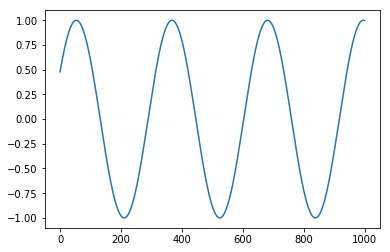

In [15]:
# generate 100 points 
nsample = 1000

## simulate a simple sinusoidal function
x1 = np.linspace(0, 10, nsample)
y = pd.Series(1*np.sin(2.0 * x1 + .5))
y.plot()

In [16]:
print(adf(y))
print('\np-value: {:0.6f}'.format(p_val(y)))

(-1165435925234116.2, 0.0, 22, 977, {'1%': -3.43706091543889, '5%': -2.8645028204932483, '10%': -2.568347558984588}, -69530.28425435597)

p-value: 0.000000


*The results indicate that the series is stationary*

## 5.2 b: Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory


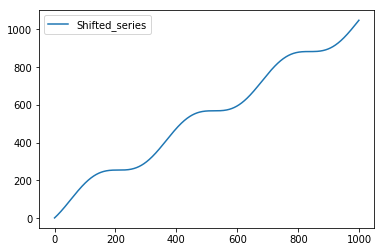

In [17]:
c_constant = 1.
y_shifted = (y + c_constant).cumsum().rename('Shifted_series').to_frame()
y_shifted.plot()

In [18]:
print(adf(y_shifted['Shifted_series']))
print('\np-value: {:0.6f}'.format(p_val(y_shifted['Shifted_series'])))

(9.077169159527749, 1.0, 15, 984, {'1%': -3.437013049776705, '5%': -2.864481711583566, '10%': -2.5683363157264196}, -57975.66656262879)

p-value: 1.000000


## 5.2.ii Apply an expanding window fracDiff, with tau=1e-2. What is the minimum *d* value do you get a p-value below 5%?

In [19]:
fd_series = fracdiff.frac_diff(y_shifted, 0.245)

In [20]:
adf(fd_series['Shifted_series'].dropna())
print('\np-value: {:0.6f}'.format(p_val(fd_series['Shifted_series'].dropna())))


p-value: 0.000000


*The minimum value of d is 0.245*

## 5.2.iii Apply FFD, with tau=1e-5. What is the minimum *d* value do you get a p-value below 5%?

In [21]:
fd_series = fracdiff.frac_diff_ffd(y_shifted, 0.999999998999)

In [22]:
adf(fd_series['Shifted_series'].dropna())
print('\np-value: {:0.6f}'.format(p_val(fd_series['Shifted_series'].dropna())))


p-value: 0.958529


*The minimum value of d is 0.999999998999*

# 5.3 Take the series from exercise 5.2.b

## (a) Fit the series to a sine function. What is the R-squared?

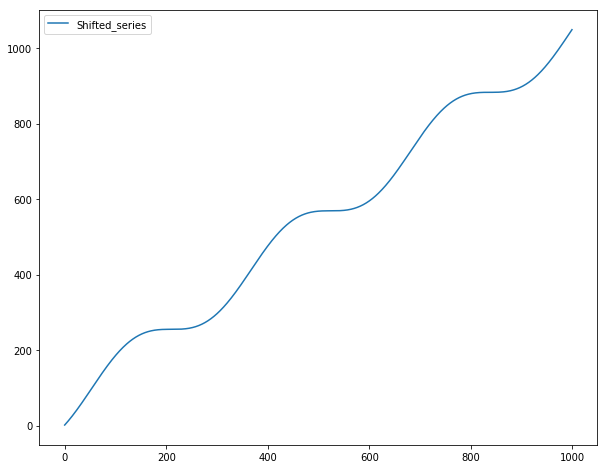

In [23]:
# take the series from 5.2.b - which is teh cumulative series (y_shifted)
y_shifted.plot(figsize=(10,8))

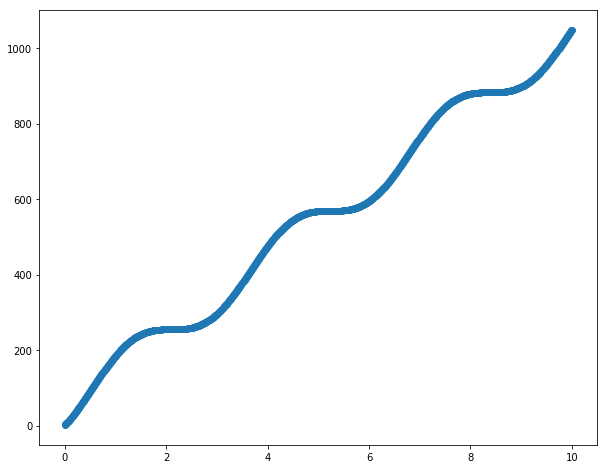

In [24]:
x_data = x1
y_data = y_shifted['Shifted_series'].values
plt.figure(figsize=(10, 8))
plt.scatter(x_data, y_data)

Taken from: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy/42322656

In [25]:
def fit_sin(tt, yy):
    ''' Fit sin to the input time sequence, and return fitting parameters 
    "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"
    '''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, 
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [26]:
res = fit_sin(x_data, y_data)

Amplitude=-848.3144837549798, Angular freq.=0.12009541980238901, phase=2.6318498303021824, 
offset=470.9669980821785, Max. Cov.=8525.818522429785


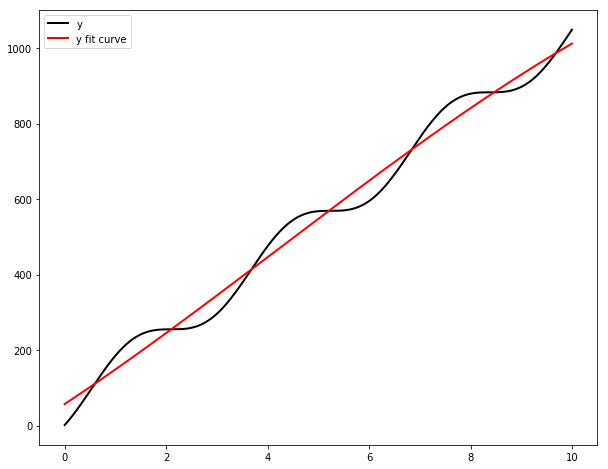

In [27]:
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, \noffset=%(offset)s, Max. Cov.=%(maxcov)s" % res )
plt.figure(figsize=(10,8))
plt.plot(x_data, y_data, "-k", label="y", linewidth=2)
plt.plot(x_data, res["fitfunc"](x_data), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [28]:
# linearly regress the computed values with those of the original values and extract the r-squared
computed_y_values = res['fitfunc'](x_data)
slope, intercept, r_val, _, _ = linregress(y_data, computed_y_values)

In [29]:
print('Slope: {:0.3f}, intercept: {:0.3f}, r-sq: {:0.3f}'.format(slope, intercept, r_val))

Slope: 0.986, intercept: 7.644, r-sq: 0.993


## 5.3.b. Apply FFD(d=1). Fit the series to a sine function. What is the r-squared?

In [30]:
fd_series = fracdiff.frac_diff_ffd(y_shifted, diff_amt=1.0).dropna()
# fd_series

In [31]:
x_data = fd_series.index
y_data = fd_series['Shifted_series'].values
res = fit_sin(x_data, y_data)

Amplitude=0.999999999999999, Angular freq.=0.02002002002002002, phase=0.49999999999999734, 
offset=0.9999999999999991, Max. Cov.=6.460741517008801e-30


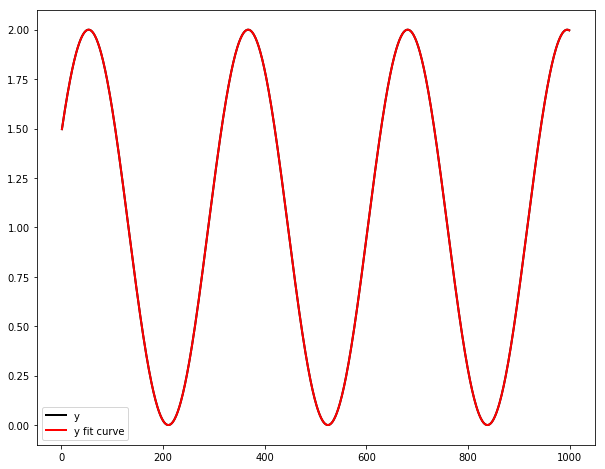

In [32]:
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, \noffset=%(offset)s, Max. Cov.=%(maxcov)s" % res )
plt.figure(figsize=(10,8))
plt.plot(x_data, y_data, "-k", label="y", linewidth=2)
plt.plot(x_data, res["fitfunc"](x_data), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [33]:
# linearly regress the computed values with those of the original values and extract the r-squared
computed_y_values = res['fitfunc'](x_data)
slope, intercept, r_val, _, _ = linregress(y_data, computed_y_values)
print('Slope: {:0.3f}, intercept: {:0.3f}, r-sq: {:0.10f}'.format(slope, intercept, r_val))

Slope: 1.000, intercept: 0.000, r-sq: 1.0000000000


## 5.3.c What value of *d* maximizes the r-squared of a sinusoidal fit on FFD(d)? why?

*The r-squared is 1.00 (that is the maximum value). fracDiff_FFD with d=1 makes the series stationary (there is no trend and it is homoscadestic) and since there is no noise the curve fit is complete.*

# 5.4 Take the dollar bar series on E-mini S&P 500 futures. Using the code in Snippet 5.3, for some d in [0, 2], compute the fracDiff_FFD(fracDiff_FFD(series, d), -d). What do you get? Why?

In [34]:
# Read in data
data = pd.read_csv('../Sample-Data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [35]:
data_series = data['close'].to_frame()

In [36]:
d = 1.5
fd = fracdiff.frac_diff_ffd(fracdiff.frac_diff_ffd(data_series, d), -d)

In [37]:
fd.isna().sum()

close    24079
dtype: int64

*The result is that the series fd is all NaNs.  The reason is when d is negative it takes an almost infinite number of observations for the weights to be lower than the threshold. That in turn leads to all the elements of the "seriesF" in frac_diff_ffd to have a value of NaNs. See the example below.*

In [38]:
d = 0.9
w = fracdiff.get_weights_ffd(d, 1e-2, 10)
w

array([[-0.0165],
       [-0.045 ],
       [-0.9   ],
       [ 1.    ]])

In [39]:
w = fracdiff.get_weights_ffd(-d, 1e-2, 10)
w

array([[0.74749788],
       [0.75589673],
       [0.76546504],
       [0.77655874],
       [0.78972075],
       [0.8058375 ],
       [0.8265    ],
       [0.855     ],
       [0.9       ],
       [1.        ]])

# 5.5 Take the dollar bar series on E-mini S&P 500 futures. 

## 5.5.a Form a new series as a cumulative sum of log prices

In [40]:
# Read in data
data = pd.read_csv('../Sample-Data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332


In [41]:
# get the close prices
data_series = data['close'].to_frame()

In [42]:
# form the cumulative sum of the log prices
log_prices = np.log(data_series).cumsum()

## 5.5.b Apply FFD, with tau = 1e-5. Determine for what d in [0, 2] the series is stationary

In [43]:
d = 1.999999979
fd_series = fracdiff.frac_diff_ffd(log_prices, diff_amt=d, thresh=1e-5)

In [44]:
p_val(fd_series['close'].dropna())

7.656261442753235e-11

In [45]:
def plot_min_ffd(close_prices):
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    for d in np.linspace(0, 1, 11):
        df1 = np.log(close_prices[['close']]).resample('1D').last()  # downcast to daily obs        
        df1.dropna(inplace=True)
        df2 = fracdiff.frac_diff_ffd(df1, diff_amt=d, thresh=0.01).dropna()
        corr = np.corrcoef(df1.loc[df2.index, 'close'], df2['close'])[0, 1]
        df2 = adfuller(df2['close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]  # with critical value
    out[['adfStat', 'corr']].plot(secondary_y='adfStat', figsize=(10, 8))
    plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    return

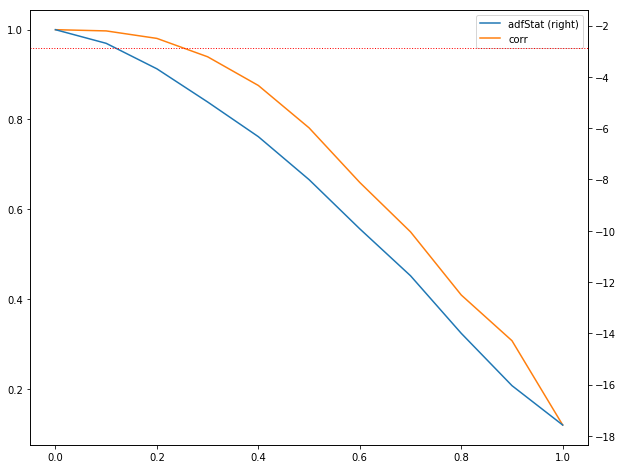

In [46]:
plot_min_ffd(data_series)

## 5.5.c Compute the correlation of fracdiff series to the original (untransformed) series

In [47]:
comb_df = log_prices.copy().rename(columns={'close':'cumsum'})
comb_df = comb_df.join(fd_series.rename(columns={'close':'fdseries'})).dropna()
comb_df = comb_df.join(data_series.rename(columns={'close':'original'})).dropna()
comb_df.head()
comb_df.corr()

,cumsum,fdseries,original
cumsum,1.000000,-0.376159,0.406330
fdseries,-0.376159,1.000000,-0.138135
original,0.406330,-0.138135,1.000000


## 5.5.d Apply an Engle-Granger cointegration test on the original and the fracdiff series. 

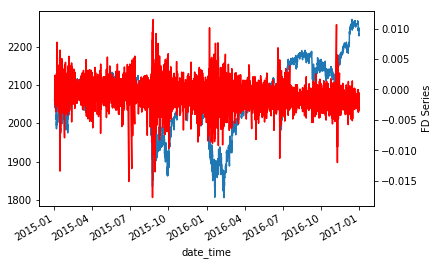

In [48]:
comb_df['original'].plot()
ax = comb_df['fdseries'].plot(secondary_y=True, color='r')
ax.set_ylabel('FD Series')
plt.show()

In [49]:
cl_prices = comb_df['original'].ravel()
fd_prices = comb_df['fdseries'].ravel()

In [50]:
res = coint(cl_prices, fd_prices, autolag='AIC')

In [51]:
print('P-value: {:.6f}'.format(res[1]))

P-value: 0.437113


*The p-value is below the critical value of 0.05, so we can reject the NULL that there is no cointegration.*

## 5.5.e Apply a Jarque-Bera normality test on the fracdiff series

In [52]:
jb_test = jarque_bera(fd_prices)
print('P-value: {:.6f}'.format(jb_test[1]))

P-value: 0.000000


*The p-value is below 0.05 critical value, so we can reject the NULL hypothesis 
that data has skewness and kurtosis matching normal distribution.  This shows that 
the underlying distribution of fd_prices is not Gaussian.*

# 5.6 Take the the fracDiff series from 5.5 

## 5.6.a Apply a CUSUM filter (Chapter 2), where h is twice the standard deviation of the series

In [53]:
# we repeat the steps of 5.5 to get the fracDiff series
# Read in data
data = pd.read_csv('../Sample-Data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

# get the close prices
data_series = data['close'].to_frame()

# form the cumulative sum of the log prices
log_prices = np.log(data_series).cumsum()

# Compute the fracDiff_FFD
d = 2.0
fd_series = fracdiff.frac_diff_ffd(log_prices, diff_amt=d, thresh=1e-5)
fd_series.head()

,close
date_time,
2015-01-01 23:00:23.723,NaN
2015-01-02 07:07:35.156,NaN
2015-01-02 09:35:57.204,-0.001697
2015-01-02 12:59:42.176,0.000243
2015-01-02 14:19:33.847,0.001333


In [54]:
# compute volatility
vol = fd_series.std()
print('Volatility: {:0.4f}'.format(vol[0]))

Volatility: 0.0014


In [55]:
# apply cusum filter
cusum_events = filters.cusum_filter(fd_series.dropna(), threshold=vol[0]*2.)
cusum_events

/media/ashu/data/Documents/WQU/Post-course/code/mlfinlab/mlfinlab/filters/filters.py:47: RuntimeWarning: divide by zero encountered in log
  diff = np.log(raw_time_series).diff()
/media/ashu/data/Documents/WQU/Post-course/code/mlfinlab/mlfinlab/filters/filters.py:47: RuntimeWarning: invalid value encountered in log
  diff = np.log(raw_time_series).diff()


DatetimeIndex(['2015-01-02 14:19:33.847000', '2015-01-02 14:33:39.311000',
               '2015-01-02 14:42:28.315000', '2015-01-02 15:57:26.907000',
               '2015-01-02 16:30:52.544000', '2015-01-02 17:11:07.124000',
               '2015-01-02 19:08:52.976000', '2015-01-02 19:29:46.490000',
               '2015-01-02 19:48:25.876000', '2015-01-02 20:47:02.488000',
               ...
               '2016-12-29 21:13:14.022000', '2016-12-30 04:04:24.654000',
               '2016-12-30 10:05:16.607000', '2016-12-30 13:51:30.230000',
               '2016-12-30 16:28:16.806000', '2016-12-30 16:53:48.389000',
               '2016-12-30 20:57:19.151000', '2016-12-30 20:58:34.724000',
               '2016-12-30 20:59:16.663000', '2016-12-30 20:59:34.157000'],
              dtype='datetime64[ns]', length=6438, freq=None)

## 5.6.b Use the filtered timestamps to sample a features' matrix. Use as one of the features the fracDiff value.

In [56]:
def relative_strength_index(df, n):
    """ Calculate Relative Strength Index(RSI) for given data.
    https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py

    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
    # df = df.join(RSI)
    return RSI


In [57]:
# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [58]:
rsi_df = get_rsi(data, window=14)

In [59]:
rsi_df.head(20)
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332


In [60]:
dol_bars_feature = data['close'].loc[cusum_events]
frac_diff_feature = fd_series.loc[cusum_events]
rsi_feature = rsi_df[cusum_events]

features_mat = (pd.DataFrame()
                .assign(dollar_bars=dol_bars_feature,
                        frac_diff=frac_diff_feature,
                        rsi=rsi_feature)
                .drop_duplicates().dropna())

features_mat.head()

,dollar_bars,frac_diff,rsi
2015-01-02 15:57:26.907,2050.50,0.001098,31.0
2015-01-02 16:30:52.544,2048.00,0.002322,35.0
2015-01-02 17:11:07.124,2050.50,0.001953,52.0
2015-01-02 19:08:52.976,2046.50,0.001956,44.0
2015-01-02 19:29:46.490,2046.75,0.000122,53.0


## 5.6.c Form labels using the triple-barrier method, with symmetric horizontal barriers of twice the daily standard deviation, and a vertical barrier of 5 days

In [61]:
# compute daily volatility
daily_vol = utils.get_daily_vol(features_mat.dollar_bars)

# compute vertical barriers
# t1 = snp.addVerticalBarrier(tEvents, ftMtx.dbars, numDays=5)
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=features_mat.dollar_bars, num_days=5)

In [62]:
# Triple barrier
pt_sl = [2, 2]
min_ret = 0.0005
triple_barrier_events = labeling.get_events(close=features_mat.dollar_bars,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers)


/media/ashu/data/Documents/WQU/Post-course/code/mlfinlab/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-07-13 14:23:53.800074 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [63]:
triple_barrier_events

,t1,trgt
2015-01-05 14:30:57.874,2015-01-05 16:49:40.508,0.001893
2015-01-05 16:49:40.508,2015-01-06 16:59:34.232,0.005317
2015-01-05 20:12:36.935,2015-01-08 14:54:32.974,0.006831
2015-01-05 20:24:35.205,2015-01-08 14:54:32.974,0.006781
2015-01-05 20:50:29.765,2015-01-08 14:54:32.974,0.006455
2015-01-05 20:55:15.175,2015-01-08 14:54:32.974,0.005993
2015-01-05 21:14:39.330,2015-01-08 12:23:50.674,0.005703
2015-01-06 12:05:40.394,2015-01-06 16:59:34.232,0.005415
2015-01-06 13:07:13.855,2015-01-06 16:59:34.232,0.005158
2015-01-06 14:34:45.441,2015-01-06 16:59:34.232,0.005059


In [64]:
# create labels
labels = labeling.get_bins(triple_barrier_events, features_mat.dollar_bars)
clean_labels = labeling.drop_labels(labels)
clean_labels.bin.value_counts()

 0    2309
 1    2233
-1    1852
Name: bin, dtype: int64

In [65]:
clean_labels.head()

,ret,trgt,bin
2015-01-05 14:30:57.874,-0.007601,0.001893,-1
2015-01-05 16:49:40.508,-0.013465,0.005317,-1
2015-01-05 20:12:36.935,0.014397,0.006831,1
2015-01-05 20:24:35.205,0.014020,0.006781,1
2015-01-05 20:50:29.765,0.013643,0.006455,1
